In [1]:
import numpy as np
from skimage.io import imread, imsave
import glob
from models.utils import get_bbox_coords
from skimage.morphology import skeletonize, opening, dilation, thin
import statistics as stats
import matplotlib.pyplot as plt
from skimage.measure import regionprops

2023-02-23 05:32:39.033859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
im_paths = sorted(glob.glob("test_images/Pos2_MAT/*000.tif"))
cp_masks_paths = sorted(glob.glob("test_images/Pos2_MAT/*masks.tif"))
ims = [imread(p) for p in im_paths]
masks = [imread(m) for m in cp_masks_paths]
len(ims), len(masks)

(101, 101)

In [3]:
isMating = True

In [4]:
MATC = [[],[]]
for i in range(len(ims)-1):
    print(i)
    I1 = ims[i].copy()
    I2 = masks[i+1].copy()
    IS6 = np.zeros_like(I2)

    if i==0:
        ccel = 1
        I3=(I2==ccel)
        r_slice, c_slice = get_bbox_coords(I3)
        I3A = I3.copy()[r_slice, c_slice]
    else:
        I3A = MATC[0][i-1].copy()[r_slice, c_slice]
    
    if isMating:
        I3A = skeletonize((I3A>0).astype(np.uint8), method="zhang")
    else:
        # just the centroid
        # dilate?
        pass
    I2A = I2.copy()[r_slice, c_slice]

    if np.sum(I2A.astype(np.uint8))==0:
        I2A = MATC[0][i-1].copy()[r_slice, c_slice]

    
    I3B = np.multiply(I3A.astype(np.uint16),(I2A.astype(np.uint16)))
    ind = stats.mode(I3B[I3B!=0])
    pix = np.nonzero(I2A==ind)

    I2A[pix] = 1

    IS6[r_slice, c_slice] = I2A.copy()
    r_slice, c_slice = get_bbox_coords(IS6)

    I22 = np.zeros_like(I2)
    pix1 = np.nonzero(IS6!=0)
    I2[pix1] = 0

    pix2 = np.unique(I2)
    pix2 = pix2[1:]
    for ity in range(0, len(pix2)):
        pix4 = np.nonzero(I2==pix2[ity])
        I22[pix4] = ity+1

    MATC[1].append(I22)
    MATC[0].append(IS6)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
ATC = 1
while np.sum(ATC)!=0:
    A1 = np.zeros((1,len(ims)))
    A4 = 1
    A5 = 1
    for i in range(len(ims)-2):
        print(i)
        A2 = opening(MATC[1][i], footprint = np.ones((3,3)))

        if A2.sum() == 0 and A5!=0:
            A1[0,i]=0
            A5 = 1
        else:
            A1[0,i]=1
            A5 = 0

            if i==0:
                ccel=1
                I3 = MATC[1][i]==ccel
                r_slice, c_slice = get_bbox_coords(I3)
                I3A = I3[r_slice, c_slice]
            elif A1[0,i]==1 and A1[0, i-1]==0 and A4!=0:
                ccel = np.min(A2[A2!=0])
                I3 = MATC[1][i]==ccel
                r_slice, c_slice = get_bbox_coords(I3)
                I3A = I3[r_slice, c_slice]
                A4 = 0
            else:
                I3A = MATC[0][i-1].copy()[r_slice, c_slice]
                I3A[I3A!=np.max(I3A)] = 0
            
            I2 = MATC[1][i+1].copy()
            I3A = skeletonize((I3A>0).astype(np.uint8), method="zhang")
            I2A = I2.copy()[r_slice, c_slice]

            if I2A.sum()==0:
                print("--1--")
                I2A = MATC[0][i-1].copy()[r_slice, c_slice]
                #print("I2A shape", I2A.shape)
                pC1 = round(I2A.shape[0]/2)
                pC2 = round(I2A.shape[1]/2)

                I2AA = np.zeros_like(I2A)
                I2AA[pC1,pC2]=1
                I2AA = dilation(I2AA, footprint = np.ones((9,9)))
                I2AA1 = np.multiply(I2AA, I2A)
                pixR = np.nonzero(I2A!=np.max(I2AA1))
                I2A[pixR] = 0
            
            I3B = np.multiply(I3A.astype(np.uint16),I2A.astype(np.uint16))

            if I3B.sum()==0:
                print("--2--")
                I2A = MATC[0][i-1].copy()[r_slice, c_slice]
                pC1 = round(I2A.shape[0]/2)
                pC2 = round(I2A.shape[1]/2)

                I2AA = np.zeros_like(I2A)
                I2AA[pC1, pC2]=1
                I2AA = dilation(I2AA,footprint = np.ones((9,9)))
                I2AA1 = np.multiply(I2AA, I2A)
                pixR = np.nonzero(I2A!=np.max(I2AA1))
                I2A[pixR] = 0
            
            I3B = np.multiply(I3A.astype(np.uint16),I2A.astype(np.uint16))
            
            if I3B.sum()==0:
                print("--3--")
                I2A = MATC[1][i].copy()[r_slice, c_slice]
                pC1 = round(I2A.shape[0]/2)
                pC2 = round(I2A.shape[1]/2)

                I2AA = np.zeros_like(I2AA)
                I2AA[pC1, pC2]=1
                I2AA = dilation(I2AA,footprint = np.ones((9,9)))
                I2AA1 = np.multiply(I2AA, I2A)
                pixR = np.nonzero(I2A!=np.max(I2AA1))
                I2A[pixR] = 0
            
            I3B = np.multiply(I3A.astype(np.uint16),I2A.astype(np.uint16))

            if I3B.sum()==0:
                print("--4--")
                I2A = MATC[1][i].copy()[r_slice, c_slice] 
                I3A = skeletonize((I2A>0).astype(np.uint8), method = "zhang") 
                I3B = np.multiply(I3A.astype(np.uint16),I2A.astype(np.uint16))
            
            ind = stats.mode(I3B[I3B!=0])
            pix = np.nonzero(I2A==ind)
            pixE = np.nonzero(I2A!=ind)
            I2A[pixE]=0

            I2A[pix] = np.max(MATC[0][-2])+1

            IS6B = np.zeros_like(I2)
            IS6B[r_slice, c_slice] = I2A.copy()
            r_slice, c_slice = get_bbox_coords(IS6B>0)
            
            pixF = np.nonzero(IS6B!=0)
            IS6C = MATC[0][i].copy()
            IS6C[pixF] = np.max(MATC[0][-2])+1

            MATC[0][i] = IS6C.copy()
            pix2 = np.nonzero(MATC[0][i]!=0)
            I2[pix2]=0

            I22 = np.zeros_like(I2)

            pix2 = np.unique(I2)
            pix2 = pix2[1:]
            for ity in range(0,len(pix2)):
                pix4 = np.nonzero(I2==pix2[ity])
                I22[pix4] = ity
            
            MATC[1][i]=I22.copy()

        ATC = np.unique(MATC[1][i])
Matmasks = [0]*(len(ims)-2)
for i in range(len(ims)-2)   :
    Matmasks[i] = MATC[0][i]     


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
--1--
40
41
42
43
44
45
46
--1--
47
48
49
50
--2--
51
--2--
52
53
54
55
--2--
56
57
58
--2--
59
--2--
60
--1--
61
62
--1--
63
--1--
64
65
66
--1--
67
68
69
70
71
--1--
72
73
--1--
74
75
76
77
78
--1--
79
--1--
80
81
--1--
82
--2--
83
--2--
84
--2--
85
--2--
86
--2--
87
--2--
88
89
90
--2--
91
--2--
92
--2--
93
94
--1--
95
--1--
96
--1--
97
--1--
98
--1--
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
--2--
38
--1--
39
40
41
--2--
42
43
44
45
--1--
46
--1--
47
48
49
50
51
--2--
52
53
54
55
56
57
58
59
60
61
62
63
64
--1--
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
--1--
46
47
48
49
--1--
50
--2--
51
52
--2--
53
54
55
56
57
58
59
60
--2--
6

In [6]:
len(Matmasks)

99

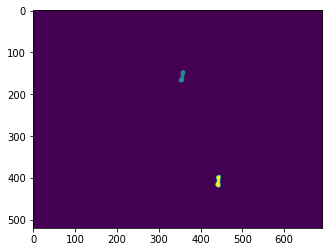

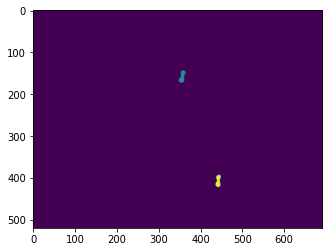

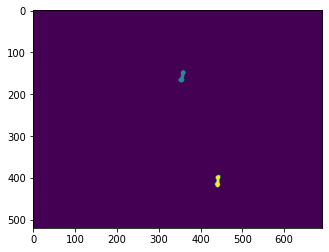

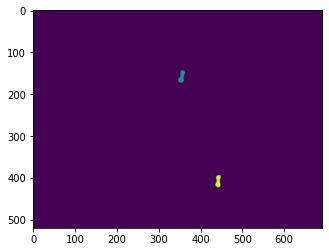

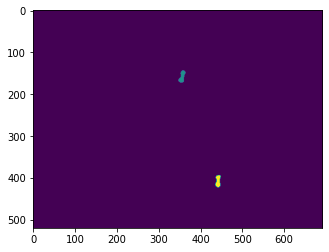

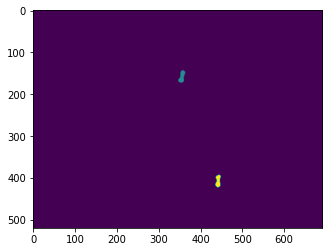

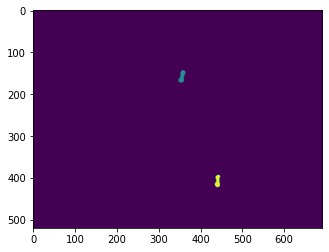

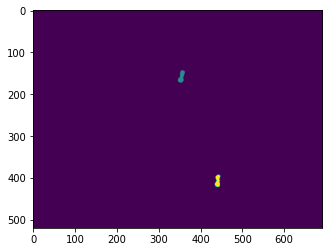

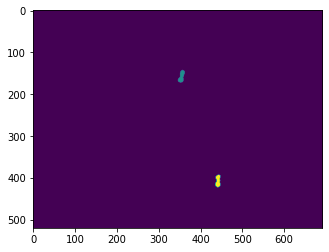

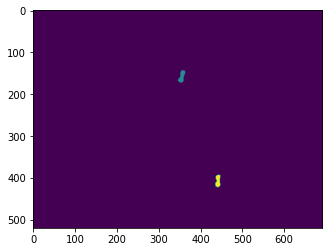

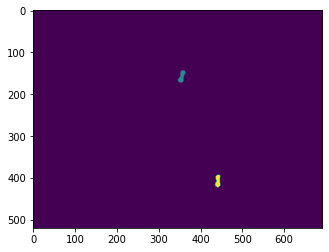

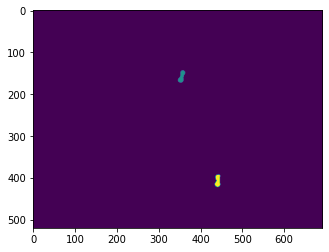

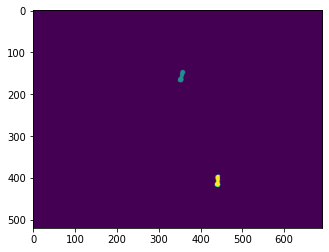

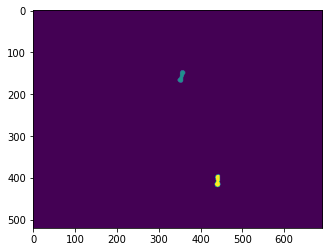

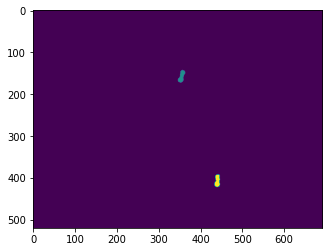

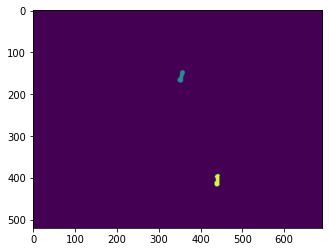

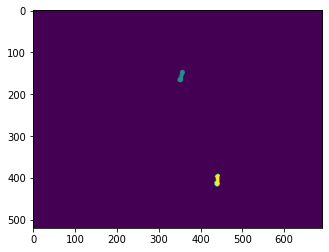

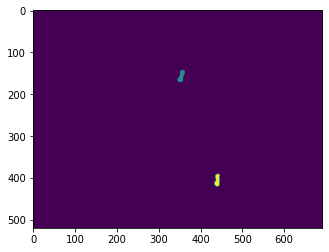

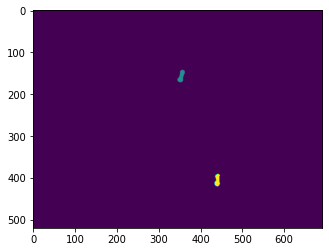

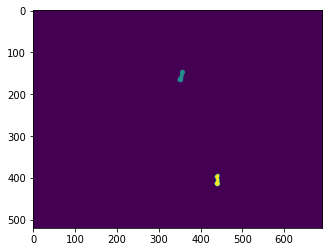

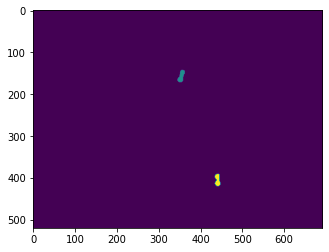

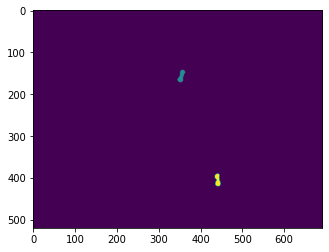

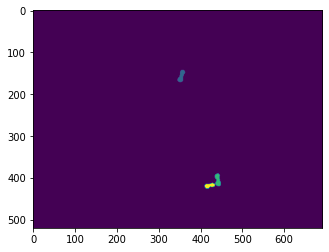

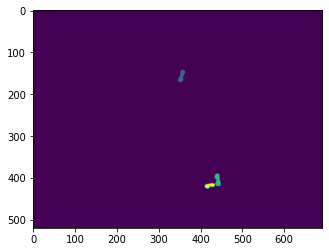

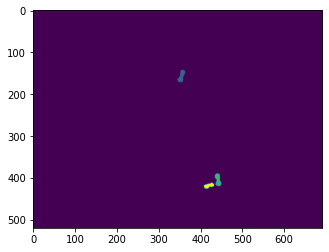

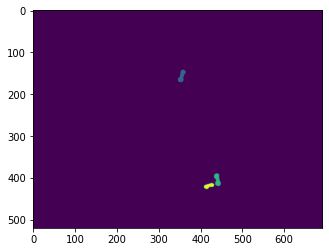

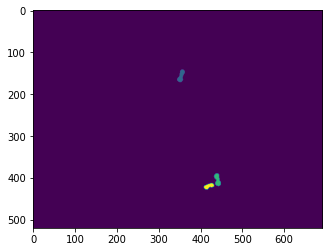

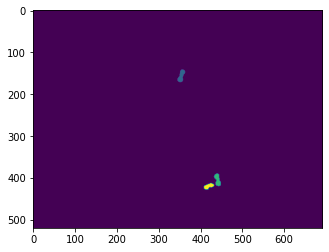

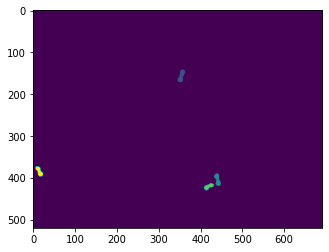

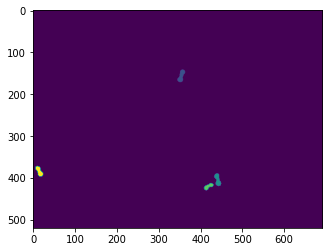

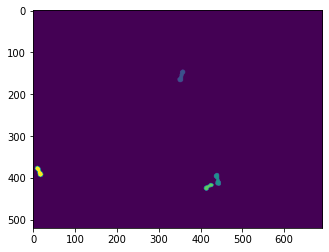

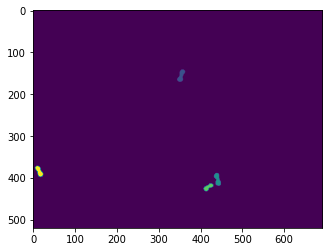

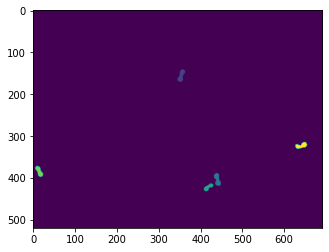

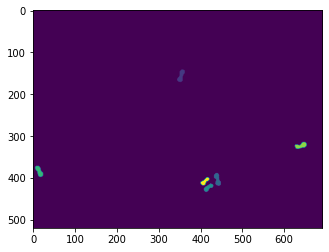

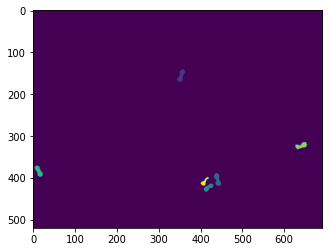

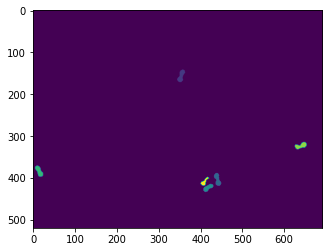

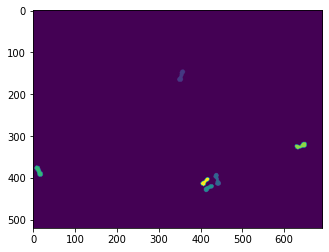

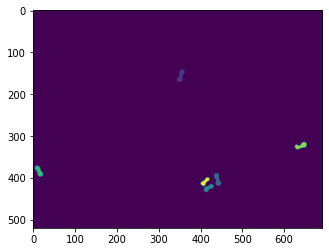

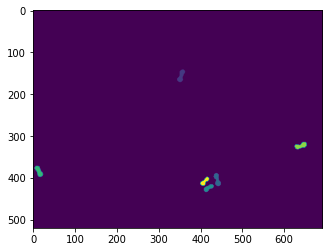

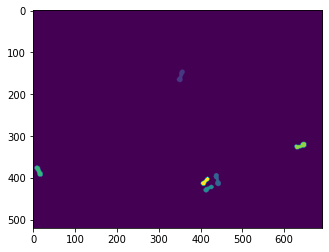

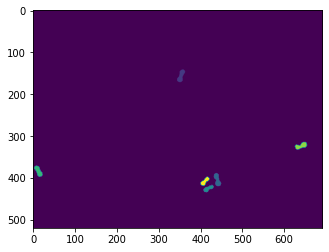

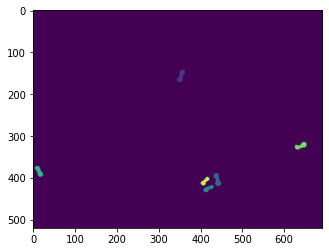

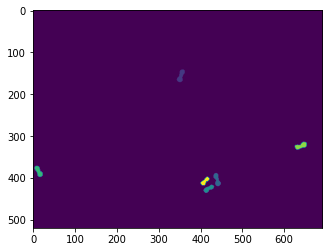

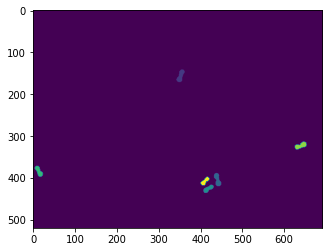

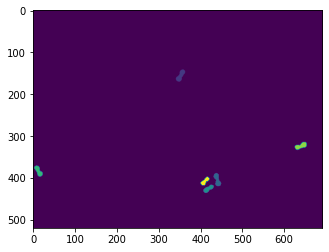

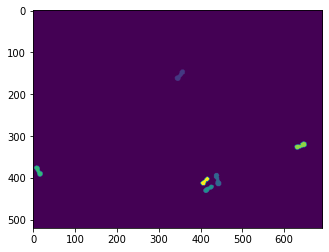

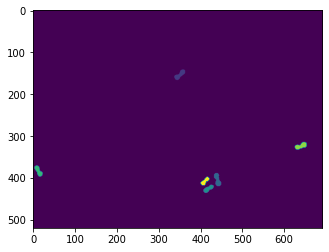

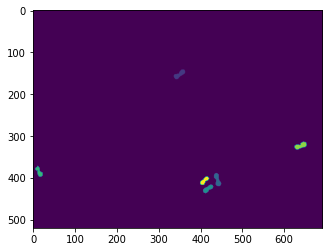

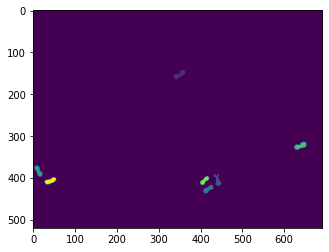

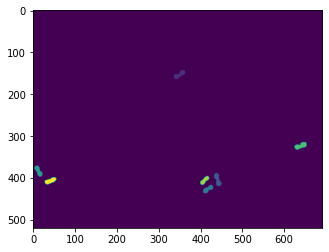

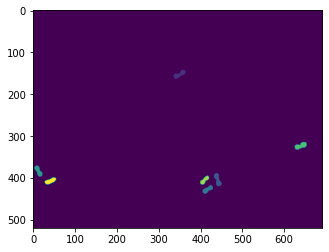

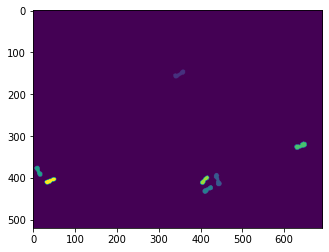

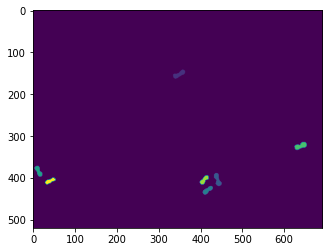

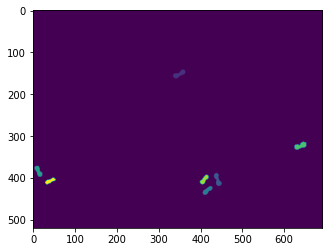

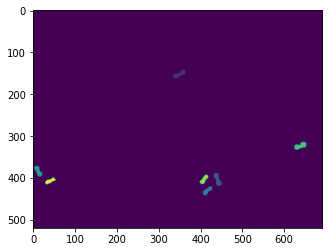

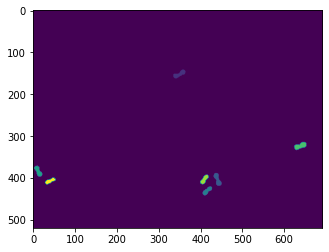

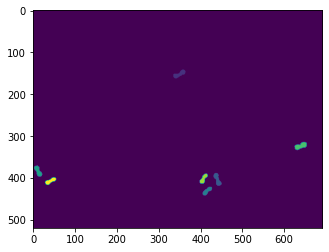

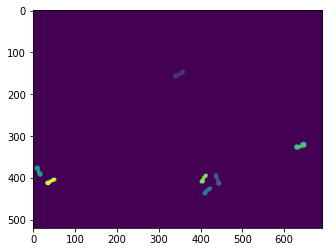

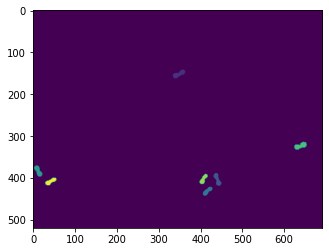

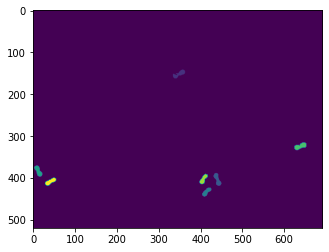

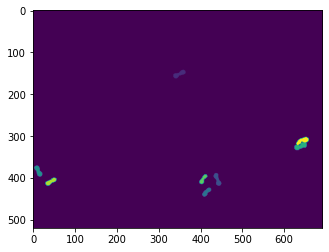

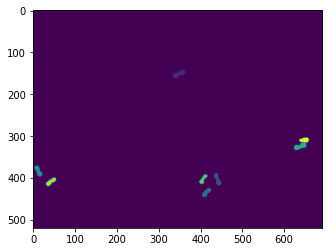

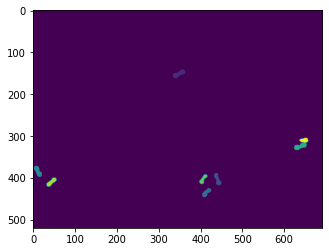

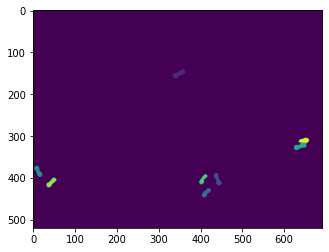

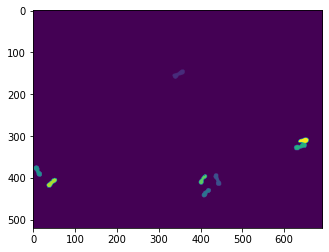

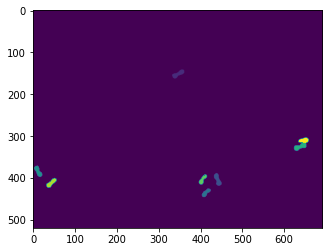

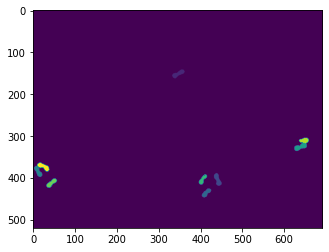

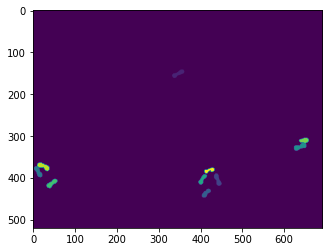

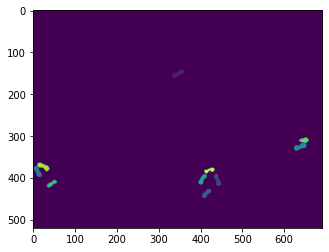

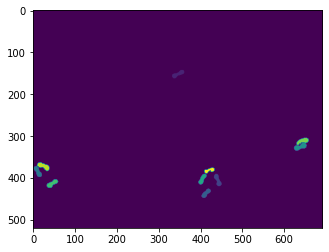

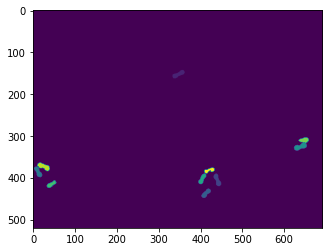

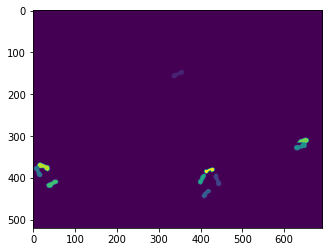

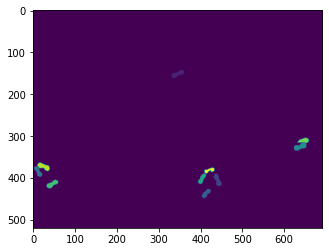

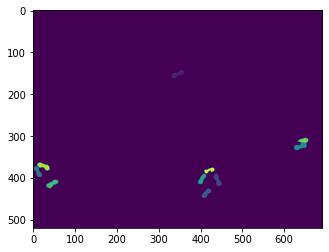

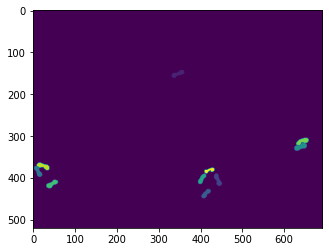

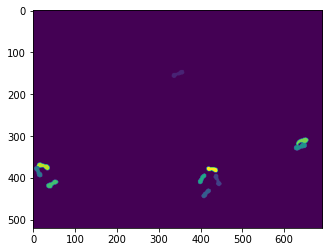

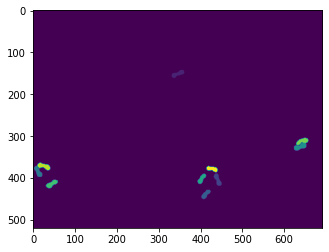

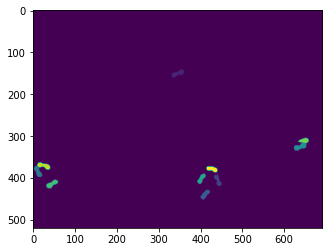

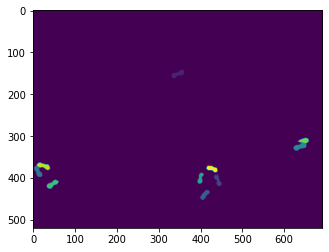

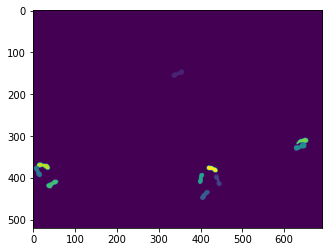

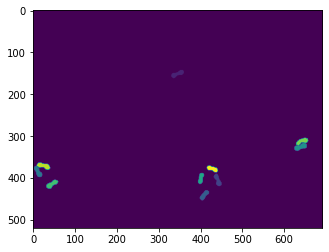

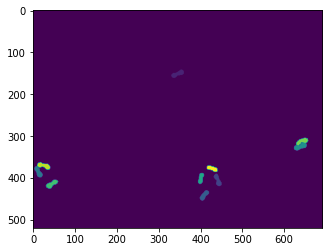

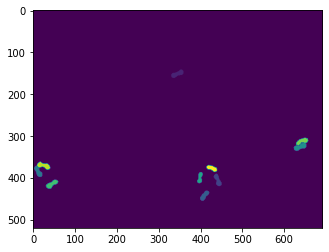

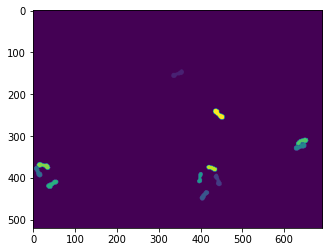

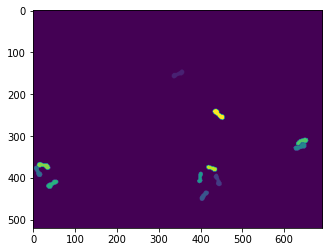

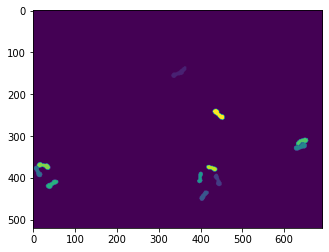

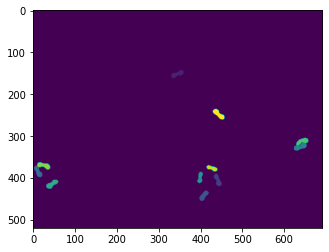

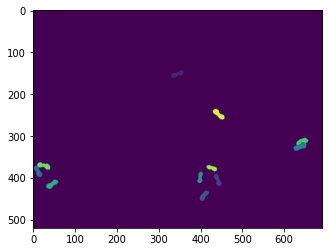

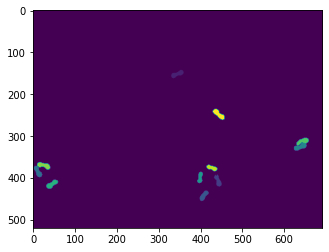

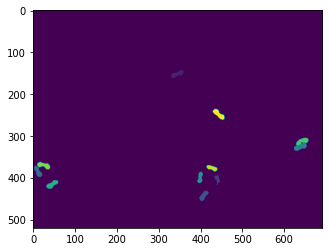

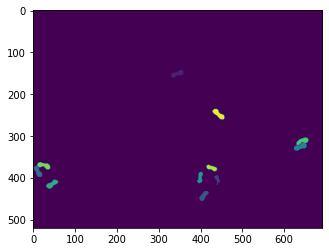

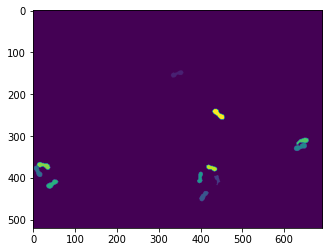

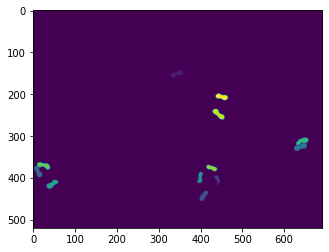

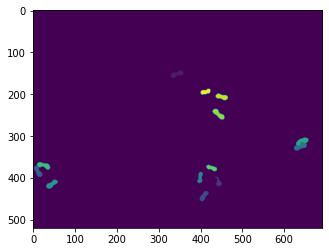

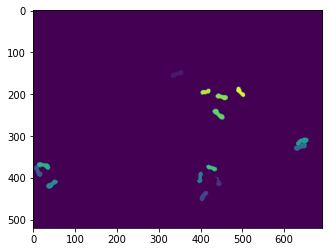

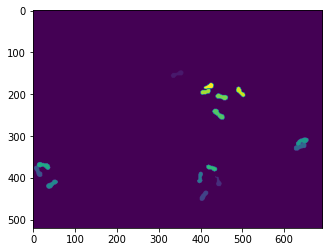

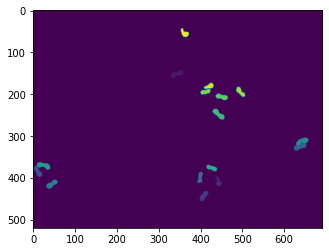

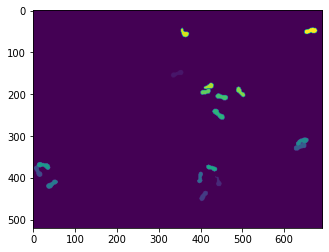

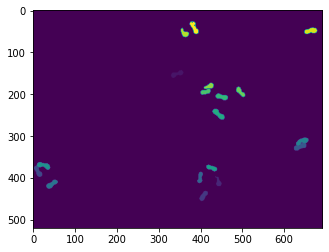

In [12]:
for im in Matmasks:
    
    # labels = regionprops(im)
    # label_string = ""
    # for label in labels:
    #     r,c = label.centroid
    #     r,c = round(r), round(c)
    #     ind = im[r,c]
    #     label_string += f" {ind} - ({c}, {r})"

    
    plt.imshow(im)
    plt.show()

In [13]:
artilife_paths = sorted(glob.glob("test_images/Pos2_ARTI/*cp_masks.tif"))
cp_masks = [imread(p) for p in artilife_paths][:99]
no_objs = np.max(Matmasks[-1])
no_objs, len(cp_masks)
len(Matmasks)
len(cp_masks)

99

In [9]:
for cxell in range(1,no_objs+1):
    for i in range(len(cp_masks)):
        I1 = ims[i]
        if cxell==1:
            I2 = cp_masks[i]
        else:
            I2 = MATC[0][i]
        I3 = Matmasks[i]
        if i == 0:
            I4 = Matmasks[i]
        else:
            I4 = Matmasks[i-1]
        
        I3 = I3==cxell

        if np.sum(I3)!=0:
            siz1 = np.count_nonzero((I3==cxell).astype(np.uint8))
            siz2 = np.count_nonzero((I4==cxell).astype(np.uint8))
            I3 = I3.astype(np.uint16)

            if siz1>siz2 + 0.2*siz2:
                r_slice, c_slice = get_bbox_coords(I4)
                I3A = (I4[r_slice, c_slice]>0).astype(np.uint8)
            else:
                r_slice, c_slice = get_bbox_coords(I3)
                I3A = (I3[r_slice, c_slice]>0).astype(np.uint8)
            
            I2A = I2[r_slice, c_slice]
            I2B1 = np.multiply(I2A, I3A.astype(np.uint16))
            I2B = thin(I2B1, max_num_iter=2)
            I2B = opening(I2B, np.ones((3,3)))
            I2BB = skeletonize((I2B>0).astype(np.uint8), method = "zhang")
            I2B1 = np.multiply(I2B1, I2BB.astype(np.uint16))
            objs = np.unique(I2B1)
            size1 = np.zeros((I2B1.shape[0], 2))
            for it1 in objs[1:]:
                A = objs[1:]==it1
                A = np.nonzero(A)[0]
                size1[:,0][A]=it1
                size1[:,1][A] = np.count_nonzero((I2B1==it1).astype(np.uint8))

            ab1 = size1.copy()

            if ab1.shape[0]!=1:
                ab1 = size1[np.argsort(size1[:,1])]
                s1 = np.count_nonzero((I2A == ab1[1,0]).astype(np.uint8))
                s2 = np.count_nonzero((I2A == ab1[0,0]).astype(np.uint8))
                if s1/s2 <= 0.25:
                    indx = ab1[0,0]
                else:
                    indx = ab1[:2,1]
            else:
                indx = ab1[0,0]
            
            indx = np.array(indx)
            
            if np.all(indx == 0):
                I2C = I3A.copy()
            elif indx.size==1:
                I2C = I2A.copy() == indx
            elif indx.size == 0:
                I2C = I3A.copy()
            else:
                I2C = np.logical_or((I2A==indx[0]), I2A==indx[1])

            I2C2 = I2A.copy()

            for ind in indx:
                I2C2[I2C2==ind]=0
            
            I2D = np.subtract(I2C, I3A)
            I2D[I2D!=0] = 1
            r1 = np.sum(I2D)/np.sum(I2C)

            if r1 <= 0.21:
                I2E = I2D + I2C
                I2E = (I2E>0).astype(np.uint8)
            elif r1 == 0:
                I2E=I2C
            elif r1 > 0.21:
                I2E = I2D+I3A
                I2E = (I2E>0).astype(np.uint8)
            
            I44 = np.zeros_like(I2)
            I44[r_slice, c_slice] = I2E
            pix = np.nonzero(I44!=0)
            I2[pix] = np.max(I2)+1

            MATC[0][i] = I2.copy()


In [11]:
len(MATC[0])

100

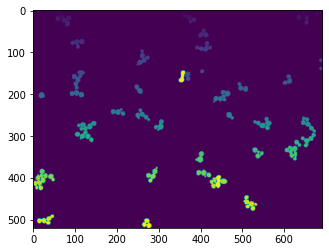

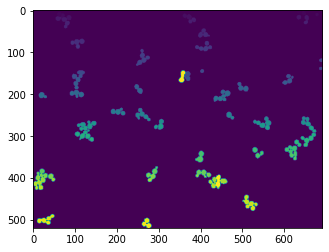

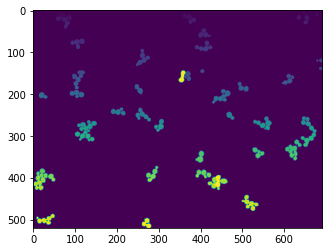

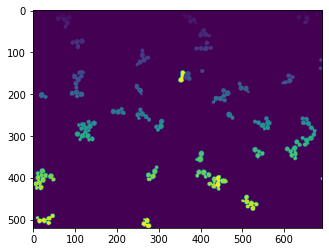

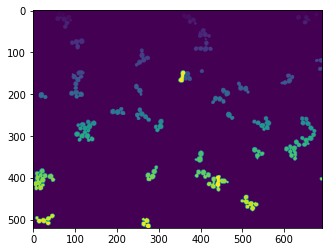

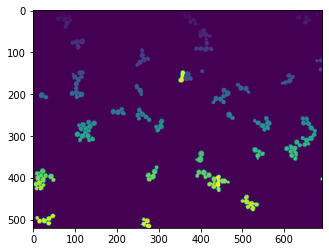

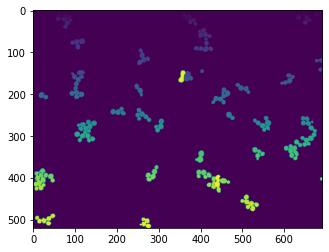

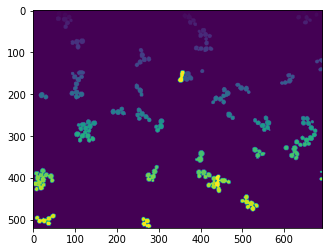

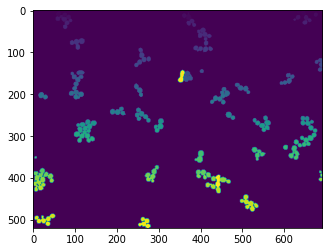

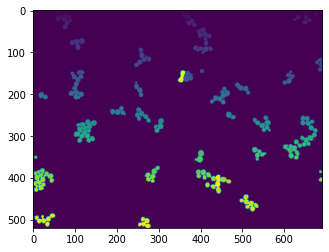

/var/folders/q1/3pqwc77s123_dkq6k5wh073h0000gp/T/ipykernel_75555/4185574206.py:6: UserWarning: test.tif is a low contrast image
  imsave("test.tif", c)


In [15]:
c = []
for im in MATC[0][:10]:
    c.append(im)
    plt.imshow(im);plt.show()
c = np.array(c)
imsave("test.tif", c)